In [ ]:
#Load Dataset
import struct
import numpy as np
import matplotlib.pyplot as plt

#==========Load IDX Files ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images[:(len(images)//(rows * cols)) * rows * cols]
        return images.reshape(-1, rows * cols).astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels[:num]

In [ ]:
# ========== 1. Sigmoid Function ==========
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# ====== 2. Mini Batch SGD: Algorithm 7.2 ======
def sgd_minibatch(X, y, eta=0.01, max_iters=10000, batch_size=64):
    n_samples, n_features = X.shape
    # 初始化權重為 0 或者小的隨機數
    w = np.zeros(n_features)

    for iter in range(max_iters):
        # random sample a mini-batch
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]

        # 預測 (用 sigmoid)
        y_pred = sigmoid(np.dot(X_batch, w))

        # 計算梯度：對 binary cross-entropy 的導數
        error = y_pred - y_batch
        grad = np.dot(X_batch.T, error) / batch_size

        # 更新權重
        w = w - eta * grad

    return w

In [ ]:
# ===== 3. Mini Batch SGD with Momentum: Algorithm 7.3 =====
def sgd_minibatch_momentum(X, y, eta=0.01, max_iters=10000, batch_size=64, momentum=0.9):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    v = np.zeros(n_features)  # 初始化 momentum

    for iter in range(max_iters):
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]

        # 計算預測與誤差
        y_pred = sigmoid(np.dot(X_batch, w))
        error = y_pred - y_batch
        grad = np.dot(X_batch.T, error) / batch_size

        # 更新 momentum 與權重
        v = momentum * v + eta * grad
        w = w - v

    return w

In [ ]:
# ====== 4. Adam Optimizer: Algorithm 7.4 ======
def sgd_Adam(X, y, eta=0.001, max_iters=10000, batch_size=64, beta1=0.9, beta2=0.999, delta=1e-8):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    m = np.zeros(n_features)  # 一階估計初始為 0
    v = np.zeros(n_features)  # 二階估計初始為 0
    t = 0  # 時間步長

    for iter in range(max_iters):
        t += 1
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]

        # 計算梯度 (先計算預測，再算誤差)
        y_pred = sigmoid(np.dot(X_batch, w))
        error = y_pred - y_batch
        grad = np.dot(X_batch.T, error) / batch_size

        # 更新一階與二階
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        # 修正bias
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        # 更新權重
        w = w - eta * m_hat / (np.sqrt(v_hat) + delta)

    return w

In [ ]:
# ========== Show Misclassified Samples ==========
def show_misclassified(X, true_labels, pred_labels, max_show=10):
    mis_idx = np.where(true_labels != pred_labels)[0][:max_show]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(mis_idx):
        plt.subplot(1, len(mis_idx), i + 1)
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"T:{true_labels[idx]}\nP:{pred_labels[idx]}")

    plt.suptitle("Misclassified Samples")
    plt.show()

In [ ]:
# ========== 預測與計算準確度 ==========
def predict(X, w):
    """
    根據輸入特徵 X 與權重 w，計算預測結果
    回傳 1 (正類) 或 0 (負類)
    """
    probs = sigmoid(np.dot(X, w))
    return (probs >= 0.5).astype(int)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

Test Accuracy: 95.98%


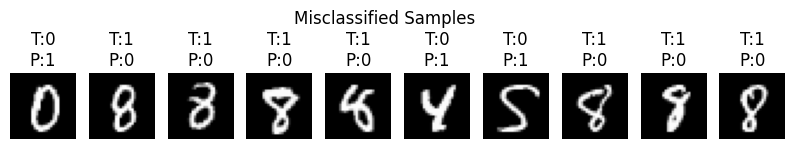

In [ ]:
if __name__ == "__main__":
  # ========== Load Data ==========
  X_train = load_images("train-images.idx3-ubyte____")
  y_train = load_labels("train-labels.idx1-ubyte____")
  X_test = load_images("t10k-images.idx3-ubyte____")
  y_test = load_labels("t10k-labels.idx1-ubyte____")

  # ========== Convert to Binary Classification ==========
  TARGET_DIGIT = 8 # Muj student ID ceslo je 110263008.

  y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0)
  y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)

  # ========== Add Bias Term ==========
  X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
  X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

  #print("[INFO] MNIST data loaded. Target digit:", TARGET_DIGIT)


  # === Set parameters ===
  optimizer_mode = "adam"  # choose "sgd", "momentum" nebo "adam"

    # === Train ===
  if optimizer_mode == "sgd":
        w = sgd_minibatch(X_train, y_train_bin, eta=0.01, max_iters=10000, batch_size=64)
  elif optimizer_mode == "momentum":
        w = sgd_minibatch_momentum(X_train, y_train_bin, eta=0.01, max_iters=10000, batch_size=64, momentum=0.9)
  elif optimizer_mode == "adam":
        w = sgd_Adam(X_train, y_train_bin, eta=0.001, max_iters=10000, batch_size=64, beta1=0.9, beta2=0.999, delta=1e-8)
  else:
      raise ValueError("IDK WTF is this optimizer mode!")

    # === Predict ===
  y_pred_test = predict(X_test, w)

    # === Evaluate ===
  test_acc = accuracy(y_test_bin, y_pred_test)
  print(f"Test Accuracy: {test_acc*100:.2f}%")

    # === Show Misclassified Samples ===
  show_misclassified(X_test, y_test_bin, y_pred_test, max_show=10)